In [15]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [16]:
class LogisticHateSpeech:
    """Logistic model using sentence embeddings to detect hate speech."""

    def __init__(self):
        """
        Initialize classifier with logistic model and encoder.
        """
        self.encoder = SentenceTransformer("all-MiniLM-L6-v2")
        self.model = LogisticRegression(penalty=None, max_iter=1000)

    def embed(self, texts: pd.Series) -> np.ndarray:
        """
        Embed text using SentenceTransformer.

        Args:
            texts (pd.Series): Input phrases.

        Returns:
            np.ndarray: Sentence embeddings.
        """
        return self.encoder.encode(texts.tolist(), show_progress_bar=False)

    def train(self, X: pd.Series, y: pd.Series) -> None:
        """
        Train the logistic regression model.

        Args:
            X (pd.Series): Text samples.
            y (pd.Series): Binary labels (0 or 1).
        """
        X_embed = self.embed(X)
        self.model.fit(X_embed, y)

    def predict_proba(self, X: pd.Series) -> pd.Series:
        """
        Predict probability of hate speech.

        Args:
            X (pd.Series): Input phrases.

        Returns:
            pd.Series: Predicted probabilities between 0 and 1.
        """
        X_embed = self.embed(X)
        proba = self.model.predict_proba(X_embed)[:, 1]
        return pd.Series(proba, index=X.index)

    def evaluate(self, X_test: pd.Series, y_test: pd.Series) -> None:
        """
        Print classification metrics using 0.25 probability threshold.

        Args:
            X_test (pd.Series): Validation text.
            y_test (pd.Series): True binary labels.
        """
        proba = self.predict_proba(X_test)
        y_pred = (proba >= 0.25).astype(int)
        print(classification_report(y_test, y_pred))


def main():
    """Train model and predict probabilities on test set."""

    train_df = pd.read_csv("../data/train_data.csv", sep=";")
    # test_df = pd.read_csv("../data/test.csv")

    train_df["isHate"] = train_df["isHate"].apply(lambda x: 1 if x >= 0.25 else 0)

    X_train, X_val, y_train, y_val = train_test_split(
        train_df["comment"], train_df["isHate"], test_size=0.2, random_state=42
    )

    model = LogisticHateSpeech()
    model.train(X_train, y_train)

    model.evaluate(X_val, y_val)

    # test_probs = model.predict_proba(test_df["text"])

    # test_df["probability"] = test_probs
    # test_df.to_csv("../data/hate_speech_predictions.csv", index=False)

if __name__ == "__main__":
    main()

              precision    recall  f1-score   support

           0       0.77      0.70      0.73       100
           1       0.72      0.79      0.76       100

    accuracy                           0.74       200
   macro avg       0.75      0.74      0.74       200
weighted avg       0.75      0.74      0.74       200



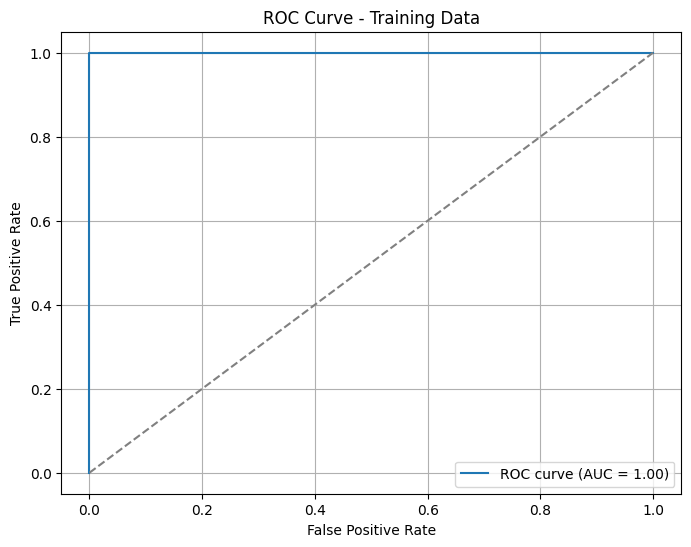

In [17]:
train_df = pd.read_csv("../data/train_data.csv", sep=";")
train_df["isHate"] = train_df["isHate"].apply(lambda x: 1 if x >= 0.25 else 0)

X_train = train_df["comment"]
y_train = train_df["isHate"]

model = LogisticHateSpeech()
model.train(X_train, y_train)

train_probs = model.predict_proba(X_train)

from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_train, train_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Training Data")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()